In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from timm import create_model
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
# Set random seed
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [3]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 15
num_classes = 2
patience = 10

In [4]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations (no augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# Load dataset
train_path = "C:/Users/lamim/Desktop/N_Thesis/split_dataset3/train"
val_path = "C:/Users/lamim/Desktop/N_Thesis/split_dataset3/val"
test_path = "C:/Users/lamim/Desktop/N_Thesis/split_dataset3/test"


In [6]:
train_data = datasets.ImageFolder(root=train_path, transform=transform)
val_data = datasets.ImageFolder(root=val_path, transform=transform)
test_data = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
# Set model name (can be changed for other ViT variants)
model_name = "vit_base_patch16_224"

# Load pretrained Vision Transformer model
model = create_model(model_name, pretrained=True)

# Replace the classification head to match number of output classes
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, num_classes)
)

# Move model to GPU or CPU
model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Adam optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Lists to store training and validation results
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# For early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    # Loop through training data
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # CutMix augmentation
        lam = np.random.beta(1.0, 1.0)
        rand_index = torch.randperm(images.size()[0]).to(device)
        target_a, target_b = labels, labels[rand_index]
        images = lam * images + (1 - lam) * images[rand_index]

        outputs = model(images)
        loss = lam * criterion(outputs, target_a) + (1 - lam) * criterion(outputs, target_b)
        loss.backward()
        optimizer.step()

        # Track training accuracy and loss
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    # Early stopping: save best model
    model_path = f'best_model_{model_name}.pth'
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            break

    # Step the learning rate scheduler
    scheduler.step()

# Load best saved model before testing
model.load_state_dict(torch.load(model_path))
model.eval()
test_loss, correct, total = 0.0, 0, 0

# Evaluate on test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

# Print final test results
test_loss /= len(test_loader)
test_acc = 100. * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:58<00:00,  1.54it/s]


Epoch 1/15, Loss: 0.7644, Accuracy: 52.6394, Val Loss: 0.7423, Val Accuracy: 44.6429


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [03:14<00:00,  1.42it/s]


Epoch 2/15, Loss: 0.6803, Accuracy: 56.1092, Val Loss: 0.6635, Val Accuracy: 61.3393


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [03:50<00:00,  1.19it/s]


Epoch 3/15, Loss: 0.6536, Accuracy: 60.4892, Val Loss: 0.6262, Val Accuracy: 64.5536


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [03:50<00:00,  1.20it/s]


Epoch 4/15, Loss: 0.6302, Accuracy: 62.6052, Val Loss: 0.6354, Val Accuracy: 68.0357


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [03:56<00:00,  1.16it/s]


Epoch 5/15, Loss: 0.6225, Accuracy: 63.3788, Val Loss: 0.5904, Val Accuracy: 70.4464


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [03:56<00:00,  1.16it/s]


Epoch 6/15, Loss: 0.6125, Accuracy: 63.2196, Val Loss: 0.5920, Val Accuracy: 72.6786


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [03:51<00:00,  1.19it/s]


Epoch 7/15, Loss: 0.6025, Accuracy: 65.8589, Val Loss: 0.5561, Val Accuracy: 75.1786


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [03:54<00:00,  1.17it/s]


Epoch 8/15, Loss: 0.6051, Accuracy: 64.4141, Val Loss: 0.5894, Val Accuracy: 72.7679


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [03:52<00:00,  1.19it/s]


Epoch 9/15, Loss: 0.6099, Accuracy: 64.5620, Val Loss: 0.5457, Val Accuracy: 75.3571


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [03:53<00:00,  1.18it/s]


Epoch 10/15, Loss: 0.5982, Accuracy: 64.2207, Val Loss: 0.5686, Val Accuracy: 72.4107


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [03:01<00:00,  1.52it/s]


Epoch 11/15, Loss: 0.5761, Accuracy: 65.6883, Val Loss: 0.5406, Val Accuracy: 74.2857


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:58<00:00,  1.54it/s]


Epoch 12/15, Loss: 0.5726, Accuracy: 67.1445, Val Loss: 0.5190, Val Accuracy: 76.3393


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:55<00:00,  1.57it/s]


Epoch 13/15, Loss: 0.5557, Accuracy: 68.7486, Val Loss: 0.4989, Val Accuracy: 78.7500


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:52<00:00,  1.59it/s]


Epoch 14/15, Loss: 0.5481, Accuracy: 67.7133, Val Loss: 0.5021, Val Accuracy: 78.3036


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:58<00:00,  1.54it/s]


Epoch 15/15, Loss: 0.5339, Accuracy: 69.9431, Val Loss: 0.4950, Val Accuracy: 78.5714
Test Loss: 0.5503, Test Accuracy: 78.7931


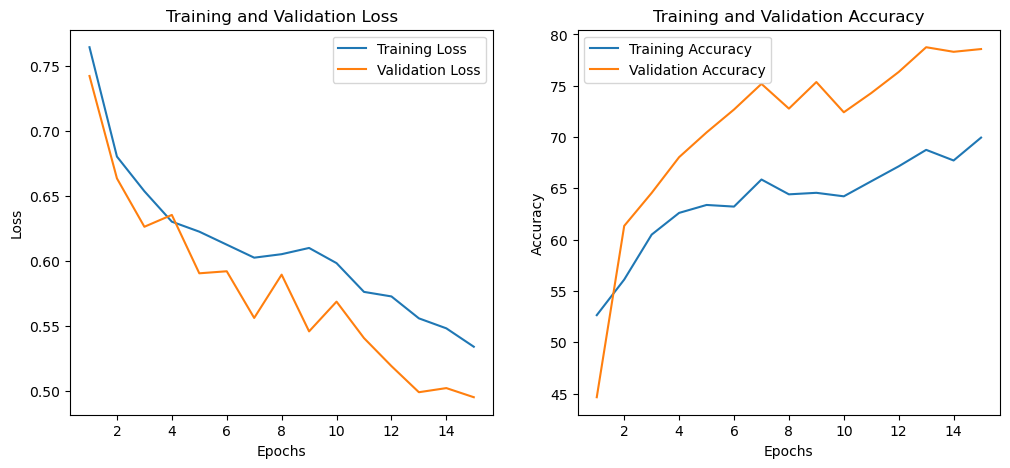

In [8]:
# Plot Training and Validation Loss and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
axes[0].plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
axes[0].plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy plot
axes[1].plot(range(1, len(train_accs)+1), train_accs, label='Training Accuracy')
axes[1].plot(range(1, len(val_accs)+1), val_accs, label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
test_labels, test_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        test_labels.extend(labels.cpu().numpy())  # Store true labels
        test_preds.extend(predicted.cpu().numpy())  # Store predicted labels

# Compute metrics for test set
test_precision = precision_score(test_labels, test_preds, average="macro")
test_recall = recall_score(test_labels, test_preds, average="macro")
test_f1 = f1_score(test_labels, test_preds, average="macro")

print(f"Test Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")


Test Precision: 0.7818, Recall: 0.7788
